### “PRP” 변수를 예측하는 LinearRegression 기반 다중 선형 회귀 모델링

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import missingno as msn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

1. 데이터 로드

In [32]:
data = pd.read_csv("machine.data.csv")
data
data.columns

Index(['VendorName', 'ModelName', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP'],
      dtype='object')

2. 데이터 탐색

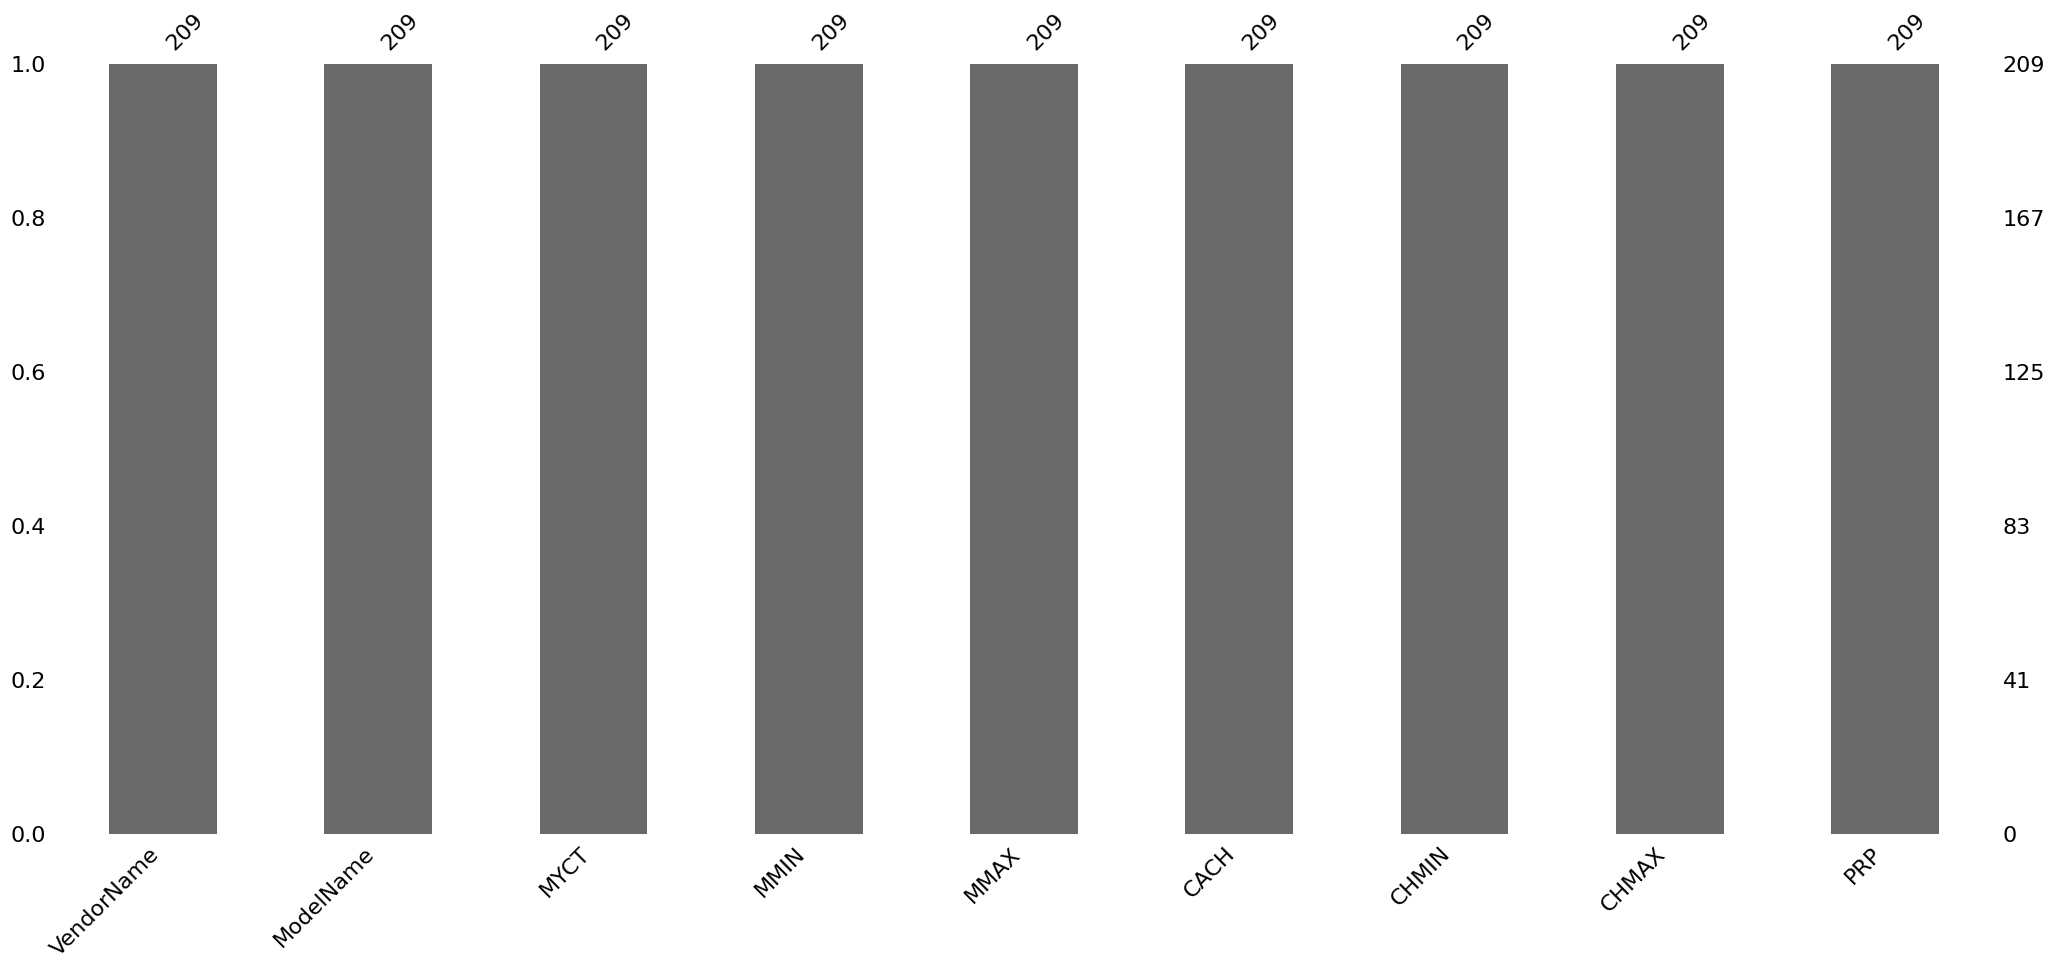

In [33]:
# 결측값 찾기
msn.bar(data)

# 결측치 처리
life.dropna(inplace = True)

3. feature engineering :  중요 특징 추출
* garbage-in Garbage-out
  * 특성의 수가 증가하는 만큼의 큰 성능 향상은 이루어지지 않는다.
  * 쓸모없는 데이터가 입력으로 들어가면 쓸모없는 결과만 나올뿐 의미

 상관도가 높은 특징을 기반으로 최적의 모형 찾기
  * 피처 선택: 속성 변수 들 중에서 어떤 변수들을 잘 조합해야 좋은 예측을 할 수 있을까
    * 상관도가(기여도)가 높은 유의한 속성 변수부터 하나씩 추가하는 방법

1) “PRP” 변수 탐색

MYCT     0
MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
PRP      0
dtype: int64


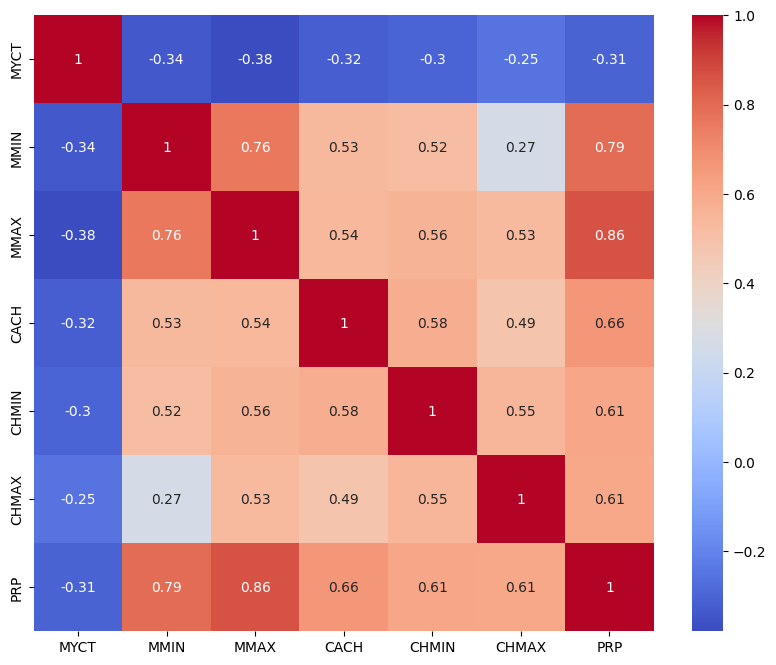

In [34]:
# 데이터셋 로드
column_names = [
    "VendorName", "ModelName", "MYCT", "MMIN", "MMAX", 
    "CACH", "CHMIN", "CHMAX", "PRP", "ERP"
]

# 전처리: 비수치형 컬럼 제거
data = data.drop(columns=['VendorName', 'ModelName'])

# 결측값 확인
print(data.isnull().sum())

# 상관관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

# 전처리된 데이터 저장
data.to_csv('preprocessed_machine_data.csv', index=False)

2) 데이터 스케일링

In [41]:
# 연속형 변수 지정
num_features = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX"]

# 전처리 파이프라인 설정
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

4. X, y 설정

In [43]:
# 데이터 분할
X = data[num_features]
y = data['PRP']  # 'PRP' 열을 종속 변수 y로 지정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5.    학습데이터와 평가데이터 분리
*  X_train, y_train : 선형회귀 학습
*  X_test, y_test: 모델 평가
  * 모델이 새로운 데이터에 대하여 어느 정도의 정확도을 보일지 예측
* 과적합: 모델이 특정한 학습 데이터에만 최적화되어 좋은 성능을 보이고, 새로운 데이터에 대해서는 좋은 성능을 나타내지 못하는 경우를 데이터의 일반화 능력이 부족

In [44]:
# X & y 차원 구하기
X.shape, y.shape 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [45]:
# 개별 모델 정의

models = [ ('lr', LinearRegression()),
          ( 'sgd', SGDRegressor( )) ]

# 앙상블 모델 정의

ensemble = VotingRegressor(estimators = models)

# 모델 파이프라인 생성

model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])


# 하이퍼파라미터 튜닝

param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}

In [46]:
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
# 최적 파라미터 출력
print(f"Best parameters found :{grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found :{'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 2000}


MSE: 7904.162166230353, MAE:48.090520406761605, R^2:0.8447328468895885


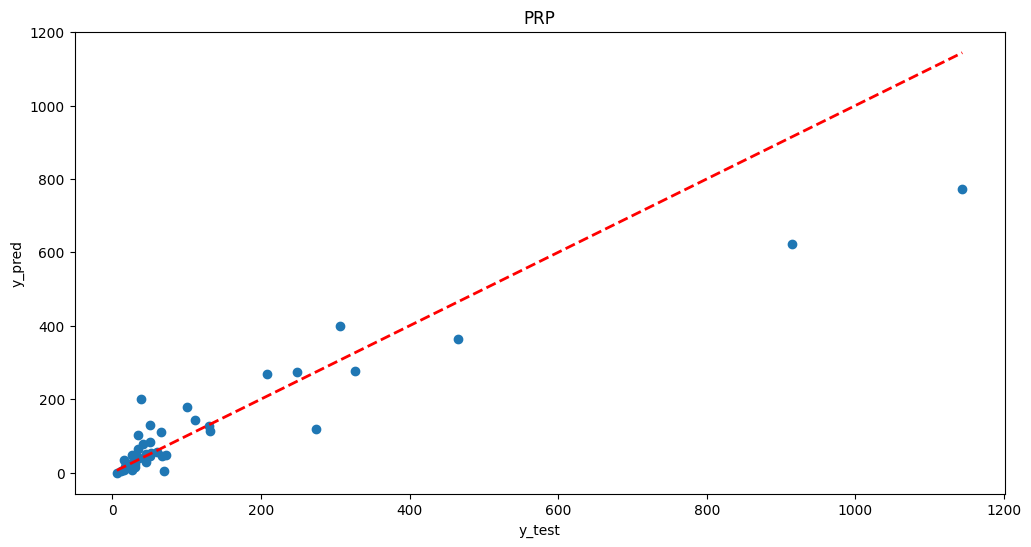

In [48]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")

plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP")
# plt.show()
plt.savefig('PRP.jpg')

In [49]:
cv_score = cross_val_score(best_model, X, y, cv = 5, scoring='neg_mean_squared_error')
print(cv_score)
cv_mse = -cv_score.mean()
print(f'Cross-Validated MSE:{cv_mse}')

[ -7530.12666743  -1531.89343345   -965.02859211  -2089.76502565
 -19628.97543515]
Cross-Validated MSE:6349.157830756383


In [50]:
train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
print(f'Training MSE: {train_mse}')

Training MSE: 3452.0178643808194
